# Computes spectral power features for later classification

In [107]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import scipy.io as sio
import os
import ieeg_funcs as ief
import dgFuncs as dg
import pickle

In [126]:
# Block for re-loading my libraries if I make updates
import imp 
imp.reload(ief) 
imp.reload(dg) 

<module 'dgFuncs' from '/Users/davidgroppe/PycharmProjects/DG_LIBRARY/dgFuncs.py'>

In [138]:
path_dict=ief.get_path_dict()
# path_dict.keys()
use_subs_df=pd.read_csv(os.path.join(path_dict['szr_ant_root'],'use_subs.txt'),header=None,na_filter=False)

In [139]:
print(use_subs_df)

    0
0  CC
1  CJ
2  CO
3  CT
4  IB
5  JW
6  NA
7  RB
8  TF


In [140]:
for sub in use_subs_df.iloc[:,0]:
    print(sub)

CC
CJ
CO
CT
IB
JW
NA
RB
TF


In [130]:
pd.read_csv?

In [ ]:
# Features:
# central window
# 1 second window, ends 1 sec previous
# mean of 10 second window, ends 1 sec previous

wind_len=1

# 1 second window, ends 1 sec previous
prev_wind_width=(1, 1, 10) # two 1 second windows and a 10 second window) 
prev_wind_delay=(0, 1, 1) # centered window, and two 1 sec before center windows 

# 10 second window, ends 1 sec previous

# Time to use:
# -all preictal data
# -10 seconds past onset window

In [33]:
# Load list of subs to use
#use_subs.txt TODO use this text file
#sub_list=['NA']
sub_list=['CO']
# TODO loop over subs
sub=sub_list[0]

In [116]:
path_dict = ief.get_path_dict()
ieeg_root = path_dict['ieeg_root']

# Get list of files to use from clinician onset csv file
onset_csv_dir=path_dict['onset_csv']
onset_csv_fname=os.path.join(onset_csv_dir,sub+'_clinician_onset_offset.csv')
print('Importing file %s' % onset_csv_fname)
onset_df=pd.read_csv(onset_csv_fname)

Importing file /Users/davidgroppe/Dropbox/TWH_INFO/CLINICIAN_ONSET_TIMES/CO_clinician_onset_offset.csv


In [35]:
onset_df.head()

,DAY,SZR#,ONSET,OFFSET,SOZ_CHAN,FILE_ONSET,DDMMYR,SRATE_HZ,NOTES,ONSET_SEC,FILE_ONSET_SEC,ONSET_TPT,DG_ONSET_CHAN,USE4CLASSIFIER,DAY.1,SZR#.1
0,11,1,10:11:29 AM,10:14:08 AM,RHD1-2,10:08:12,10/01/2010,250,?,36689,36492,49250,RHD1-2,clinicianOnsetTooEarly,11,1
1,11,2,2:36:00 PM,2:27:46 PM,NaN,14:32:42,10/01/2010,250,?,52560,52362,49500,LHD1-2,use,11,2
2,12,1,4:21:38 AM,4:22:08 AM,?,13:22:04,10/02/2010,250,?,15698,48124,-8106500,?,clinicianOnsetIncorrect,12,1
3,12,2,3:40:30 AM,3:40:55 AM,?,20:26:52,10/02/2010,250,?,13230,73612,-15095500,?,clinicianOnsetIncorrect,12,2
4,12,3,1:24:41 PM,1:26:18 PM,?,04:20:07,10/03/2010,250,?,48281,15607,8168500,?,clinicianOnsetIncorrect,12,3


In [45]:
onset_df.shape

(20, 16)

In [81]:
use_ser=onset_df['USE4CLASSIFIER']
use_szrs=list()
# onset_chans=list()
for row_id, quality in enumerate(use_ser):
    if quality=='use':
        szr_name=sub+'_d'+str(onset_df.iloc[row_id,0])+'_sz'+str(onset_df.iloc[row_id,1])
        use_szrs.append(szr_name)
#         onset_chans.append(onset_df.iloc[row_id,12])
n_use_szrs=len(use_szrs)
print('%d usable szrs:' % n_use_szrs)
print(use_szrs)
# print(onset_chans)

3 usable szrs:
['CO_d11_sz2', 'CO_d8_sz3', 'CO_d9_sz1']


In [28]:
# Figure out how many time windows of data we'll have so we can preallocate memory?
ieeg_root

'/Users/davidgroppe/ONGOING/TWH_EEG/'

In [54]:
len(bands)

5

In [59]:
# Define frequency bands
bands=list()
bands.append((1,4)) # Delta
bands.append((4,8)) # Theta
bands.append((8,13)) # Alpha
bands.append((13,30)) # Beta
bands.append((30,50)) # Gamma
bands.append((70,100)) # High Gamma

In [60]:
# Block for re-loading my libraries if I make updates
import imp 
imp.reload(ief) 
imp.reload(dg) 

200.0

In [71]:
ieeg.shape

(23, 76250)

In [72]:
#bro=ieeg[onset_chan_id:onset_chan_id+1,:]
bro=ieeg[22:23,:]
bro.shape

(1, 76250)

In [86]:
print(use_szrs[0:1])
print(szr)

['CO_d11_sz2']


NameError: name 'szr' is not defined

In [121]:
# Import channel names
chan_labels=ief.import_chan_labels(sub)
ftr_list=list()
ftr_class_list=list()

# Loop over usable files
#for szr_ct, szr_name in enumerate(use_szrs[0:1]): # ?? REVERT
for szr_ct, szr_name in enumerate(use_szrs):
    # Load data
    in_fname=os.path.join(ieeg_root,sub,'EEG_MAT',szr_name+'.mat')
    if not os.path.isfile(in_fname):
        # Must be a subclinical seizure
        in_fname=os.path.join(ieeg_root,sub,'EEG_MAT',szr_name+'_sc.mat')
    szr_name_full=in_fname.split('/')[-1]
    ieeg, Sf, tpts_sec=ief.import_ieeg(szr_name_full)

    # Adjust upper frequency band based on sampling rate
    bands[5]=(70,Sf*.4)
    print(bands)
    
    # Get time point and channel of szr onset
    onset_tpt, onset_chan=ief.clin_onset_tpt_and_chan(szr_name, onset_df)
    onset_chan_id = chan_labels.index(onset_chan)
    onset_sec=tpts_sec[onset_tpt]
    print(onset_sec)
    print(onset_tpt)
    print(onset_chan)
    
    # Run DFT 
    wind_len=Sf
    wind_step=Sf/10
    n_tapers=4
    db_pwr, sgram_sec=ief.bp_pwr(ieeg[onset_chan_id:onset_chan_id+1,:], Sf, wind_len, wind_step,
                                 n_tapers, tpts_sec, bands, taper='slepian')
    db_pwr=np.squeeze(db_pwr)
    # Trim norm
    dg.trimmed_normalize(db_pwr,.4)
    
    # Record class of each time point
    n_wind=len(sgram_sec)
    sgram_onset_id=dg.find_nearest(sgram_sec,onset_sec-4)
    sgram_term_id=dg.find_nearest(sgram_sec,onset_sec+9)
    peri_ictal=np.ones(n_wind,dtype=np.int8)
    peri_ictal[:sgram_onset_id]=0
    peri_ictal[sgram_term_id:]=-1 # ictal (and potentially post-ictal data) that should 
    # not be used for classification
    
    # output data
    ftrs_root=path_dict['ftrs_root']
    ftr_path=os.path.join(ftrs_root,'PWR',sub)
    if not os.path.isdir(ftr_path):
        os.mkdir(ftr_path)
    ftr_fname=os.path.join(ftr_path,szr_name+'_bppwr.npz')
    print('Saving features to file %s' % ftr_fname)
    np.savez(ftr_fname,peri_ictal=peri_ictal,time_wind_sec=sgram_sec,db_pwr=db_pwr)
#     ftr_fname=os.path.join(ftrs_root,'PWR',szr_name+'_bppwr.pkl')
#     pkl_handle=open(ftr_fname,'wb')
#     pickle.dump(ftr_fname,pkl_handle)
#     close(pkl_handle)

print('Done!')

Loading /Users/davidgroppe/ONGOING/TWH_EEG/CO/CO_channel_info.csv
Loading /Users/davidgroppe/ONGOING/TWH_EEG/CO/EEG_MAT/CO_d11_sz2.mat
[(1, 4), (4, 8), (8, 13), (13, 30), (30, 50), (70, 100.0)]
Getting clinical onset time for CO: Day 11, Szr 2
198.0
49500
LHD1-2
chans 1
tpts 76250
6 dimensions
3040 observations
Saving features to file /Users/davidgroppe/PycharmProjects/SZR_ANT/FTRS/PWR/CO/CO_d11_sz2_bppwr.npz
Loading /Users/davidgroppe/ONGOING/TWH_EEG/CO/EEG_MAT/CO_d8_sz3_sc.mat
[(1, 4), (4, 8), (8, 13), (13, 30), (30, 50), (70, 100.0)]
Getting clinical onset time for CO: Day 8, Szr 3
48.0
12000
LHD1-2
chans 1
tpts 14750
6 dimensions
580 observations
Saving features to file /Users/davidgroppe/PycharmProjects/SZR_ANT/FTRS/PWR/CO/CO_d8_sz3_bppwr.npz
Loading /Users/davidgroppe/ONGOING/TWH_EEG/CO/EEG_MAT/CO_d9_sz1.mat
[(1, 4), (4, 8), (8, 13), (13, 30), (30, 50), (70, 100.0)]
Getting clinical onset time for CO: Day 9, Szr 1
134.0
33500
LHD1-2
chans 1
tpts 48750
6 dimensions
1940 observatio

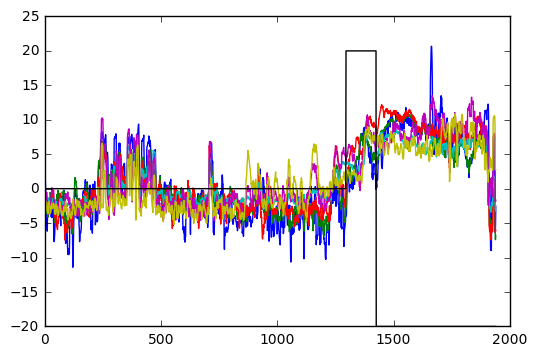

In [122]:
# db_pwr=np.squeeze(db_pwr)
# dg.trimmed_normalize(db_pwr,.4)
_=plt.plot(db_pwr.T)
_=plt.plot(peri_ictal*20,'k-')
# _=plt.plot(db_pwr[0,:,:].T)
# db_pwr.shape

In [90]:
bro=np.squeeze(db_pwr)
bro.shape

(6, 3040)

In [ ]:
os.ex